In [162]:
import concurrent.futures
import time
import sys
from dimod import DiscreteQuadraticModel
from dwave.system import LeapHybridDQMSampler
import pandas as pd
import numpy as np
import seaborn as sns
from distance_matrix_creator import *
import matplotlib.pyplot as plt
import dwave.inspector

In [163]:
Nfacil = 14
factory_rows = 9
factory_collumns = 9
Npos = factory_rows*factory_collumns
positions = []
facilities = [i for i in range(Nfacil)]
positions = [i for i in range(Npos)]
np.set_printoptions(linewidth=1000, suppress=True,threshold= sys.maxsize)
flow = pd.read_csv("csv_files/flowmatrixdqm.csv", header = None)
flow = (flow.to_numpy()/3)**3
flow = np.round(flow)
flow = np.triu(flow)
flow = np.array(flow)
print(flow,"\n\n")


distance = rectdistancematrix(factory_rows,factory_collumns)
# distance = np.round(distance,decimals=3)
distance = np.triu(np.array(distance))
distance = (np.array(distance))#**3)/5
distance = np.round(distance,decimals=3)
print(distance)
print(np.shape(distance))

print("Facilities = ", facilities)
print("Positions = ",positions)

facility_size_noempty = [10,4,7,4,2,1,14,2,14,3,1,3,2]
emptyspace = [Npos - np.sum(facility_size_noempty)]
facility_size = emptyspace + facility_size_noempty

[[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
 [ 0. 81.  8.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0. 81.  8.  8.  8.  1.  1.  2.  0.  2.  2.  1.  2.]
 [ 0.  0.  0. 81.  2.  5.  1.  0.  0.  0.  0.  0. -2.  0.]
 [ 0.  0.  0.  0. 81.  1.  5.  0.  2.  0.  0.  0. -2.  0.]
 [ 0.  0.  0.  0.  0. 81.  2.  5.  1.  0.  0.  0. -2.  0.]
 [ 0.  0.  0.  0.  0.  0. 81.  1.  5.  0.  1.  0. -2.  0.]
 [ 0.  0.  0.  0.  0.  0.  0. 81.  2.  5.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0. 81.  5.  1.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0. 81.  5.  5.  1.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0. 81.  2.  1.  2.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. 81.  1.  2.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. 81.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. 81.]] 


[[ 0.     1.     2.     3.     4.     5.     6.     7.     8.     1.     1.414  2.236  3.162  4.123  5.099  6.083  7.071  8.062  2.     2.236  2.828  3.606  4.472  5.385 

#Building a Variable for each Position

In [164]:
labels = []
for p in positions:
    labels.append(f'P{p}')
print(np.array(labels))

['P0' 'P1' 'P2' 'P3' 'P4' 'P5' 'P6' 'P7' 'P8' 'P9' 'P10' 'P11' 'P12' 'P13' 'P14' 'P15' 'P16' 'P17' 'P18' 'P19' 'P20' 'P21' 'P22' 'P23' 'P24' 'P25' 'P26' 'P27' 'P28' 'P29' 'P30' 'P31' 'P32' 'P33' 'P34' 'P35' 'P36' 'P37' 'P38' 'P39' 'P40' 'P41' 'P42' 'P43' 'P44' 'P45' 'P46' 'P47' 'P48' 'P49' 'P50' 'P51' 'P52' 'P53' 'P54' 'P55' 'P56' 'P57' 'P58' 'P59' 'P60' 'P61' 'P62' 'P63' 'P64' 'P65' 'P66' 'P67' 'P68' 'P69' 'P70' 'P71' 'P72' 'P73' 'P74' 'P75' 'P76' 'P77' 'P78' 'P79' 'P80']


#Initialise BQM

In [165]:
dqm = DiscreteQuadraticModel()
for p in positions:
    dqm.add_variable(Nfacil, label=labels[p])
# print(dqm)
print(dqm.variables)

Variables(['P0', 'P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'P9', 'P10', 'P11', 'P12', 'P13', 'P14', 'P15', 'P16', 'P17', 'P18', 'P19', 'P20', 'P21', 'P22', 'P23', 'P24', 'P25', 'P26', 'P27', 'P28', 'P29', 'P30', 'P31', 'P32', 'P33', 'P34', 'P35', 'P36', 'P37', 'P38', 'P39', 'P40', 'P41', 'P42', 'P43', 'P44', 'P45', 'P46', 'P47', 'P48', 'P49', 'P50', 'P51', 'P52', 'P53', 'P54', 'P55', 'P56', 'P57', 'P58', 'P59', 'P60', 'P61', 'P62', 'P63', 'P64', 'P65', 'P66', 'P67', 'P68', 'P69', 'P70', 'P71', 'P72', 'P73', 'P74', 'P75', 'P76', 'P77', 'P78', 'P79', 'P80'])


#Objective function

In [166]:
for j in range(len(positions)):
    for jj in range(j+1,len(positions)):
        for i in range(Nfacil):
            for ii in range(Nfacil):
                if i == 0 or ii == 0:
                    dqm.set_quadratic_case(labels[j],i,labels[jj],ii,distance[j][jj]*flow[i][ii])
                else:    
                    dqm.set_quadratic_case(labels[j],i,labels[jj],ii,distance[j][jj]*flow[i][ii]/i*ii)

#constraint 1: only 1 machine is placed per position

In [167]:
# for p in positions:
#     for f in facilities:
#         dqm.add_linear_equality_constraint(
            
#         )
for f in range(1,Nfacil):
    # if f == 0:
    #     c1 = [(labels[p],f,1) for p in positions]
    # else:
    #     c1 = [(labels[p],f,1/f) for p in positions]
    c1 = [(labels[p],f,1/f) for p in positions]
    print(c1)
    dqm.add_linear_equality_constraint(
        c1,
        constant=-1*facilities[f],
        lagrange_multiplier=1000
    )


[('P0', 1, 1.0), ('P1', 1, 1.0), ('P2', 1, 1.0), ('P3', 1, 1.0), ('P4', 1, 1.0), ('P5', 1, 1.0), ('P6', 1, 1.0), ('P7', 1, 1.0), ('P8', 1, 1.0), ('P9', 1, 1.0), ('P10', 1, 1.0), ('P11', 1, 1.0), ('P12', 1, 1.0), ('P13', 1, 1.0), ('P14', 1, 1.0), ('P15', 1, 1.0), ('P16', 1, 1.0), ('P17', 1, 1.0), ('P18', 1, 1.0), ('P19', 1, 1.0), ('P20', 1, 1.0), ('P21', 1, 1.0), ('P22', 1, 1.0), ('P23', 1, 1.0), ('P24', 1, 1.0), ('P25', 1, 1.0), ('P26', 1, 1.0), ('P27', 1, 1.0), ('P28', 1, 1.0), ('P29', 1, 1.0), ('P30', 1, 1.0), ('P31', 1, 1.0), ('P32', 1, 1.0), ('P33', 1, 1.0), ('P34', 1, 1.0), ('P35', 1, 1.0), ('P36', 1, 1.0), ('P37', 1, 1.0), ('P38', 1, 1.0), ('P39', 1, 1.0), ('P40', 1, 1.0), ('P41', 1, 1.0), ('P42', 1, 1.0), ('P43', 1, 1.0), ('P44', 1, 1.0), ('P45', 1, 1.0), ('P46', 1, 1.0), ('P47', 1, 1.0), ('P48', 1, 1.0), ('P49', 1, 1.0), ('P50', 1, 1.0), ('P51', 1, 1.0), ('P52', 1, 1.0), ('P53', 1, 1.0), ('P54', 1, 1.0), ('P55', 1, 1.0), ('P56', 1, 1.0), ('P57', 1, 1.0), ('P58', 1, 1.0), ('P59'

#Constraint 2: only 1 position is chosen per facility

In [168]:
# for f in facilities:
#     c2 = [(x[f][p],1) for p in positions]
#     bqm.add_linear_equality_constraint(
#         c2,
#         constant=-1*facility_size[f],
#         lagrange_multiplier=300,
#         # label = "c2_facil_" + str(f)
#     )

Removing 0 bias variables and couplers from BQM

In [169]:
# new_bqm = BinaryQuadraticModel(bqm.linear, {interaction: bias for interaction, bias in bqm.quadratic.items() if bias}, bqm.offset, bqm.vartype)
file = open("txt_files/dqm.txt", "w")
# file.write(dqm)
file.close()
print(dqm)
# file2 = open("txt_files/new_bqm.txt", "w")
# file2.write(str(new_bqm))
# file2.close()

#running the solver

In [170]:
sampler = LeapHybridDQMSampler()
# numreads = 200 #number of samples for simulated annealer
timelimit = 10 #time limit for hybrid sampler
sampleset = sampler.sample_dqm(dqm,time_limit=timelimit)

Printing Output Solutions

   P0 P1 P2 P3 P4 P5 P6 P7 P8 P9 P10 P11 P12 P13 ... P80        energy num_oc.
6  13 13 13  8  8  6  6  6  4 13  13  13   8   8 ...   1 698547.544604       1
22 13 13 13  8  8  6  6  6  4 13  13  13   8   8 ...   1 698547.544604       1
2  13 13 13  6  6  6  6  3  3 13  13  13   6   6 ...   7 698557.145749       1
4  13 13 13  6  6  6  6  3  3 13  13  13   6   6 ...   7 698557.145749       1
8  13 13 13  6  6  6  6  3  3 13  13  13   6   6 ...   7 698557.145749       1
9  13 13 13  6  6  6  6  3  3 13  13  13   6   6 ...   7 698557.145749       1
12 13 13 13  6  6  6  6  3  3 13  13  13   6   6 ...   7 698557.145749       1
15 13 13 13  6  6  6  6  3  3 13  13  13   6   6 ...   7 698557.145749       1
16 13 13 13  6  6  6  6  3  3 13  13  13   6   6 ...   7 698557.145749       1
17 13 13 13  6  6  6  6  3  3 13  13  13   6   6 ...   7 698557.145749       1
18 13 13 13  6  6  6  6  3  3 13  13  13   6   6 ...   7 698557.145749       1
23 13 13 13  6  6  6  6  3  3 13  13  13   6   6 ...

[Text(0.5, 1.0, 'Final Layout')]

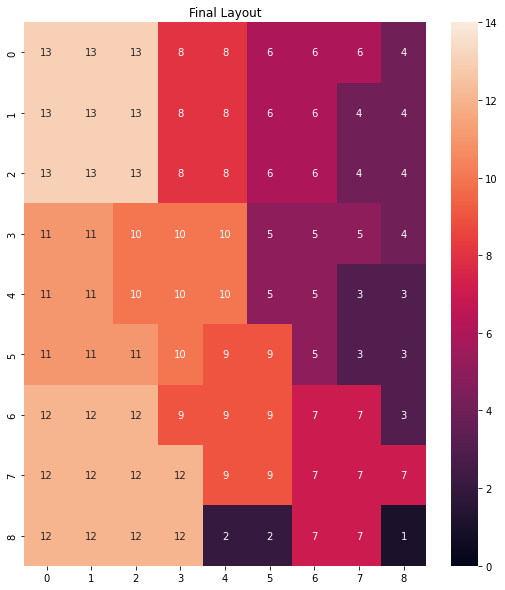

In [171]:
t3 = time.time()
print(sampleset)
sample = sampleset.first.sample
# print(sample)

layout_val = sample.values()
layout_val = np.array(list(layout_val))
# print(layout_val)

for f in facilities:
    if (layout_val==f).sum() != facility_size[f]:
        print(f"incorrect size of facility {f}, correct size = {facility_size[f]}, calculated size = {(layout_val==f).sum()}")



layout = layout_val.reshape(factory_rows,factory_collumns)
fig, ax = plt.subplots(figsize=(9, 10))
sns.heatmap(layout,annot = layout, vmin = 0, vmax = len(facilities)).set(title = "Final Layout")